In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 


from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for images, labels in test_loader:
    print(f'Batch size: {images.size(0)}') 
    break 


Batch size: 64


In [12]:
device = 'mps'

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
tf = transforms.Compose([transforms.ToTensor(),
 transforms.Normalize((0.1307,), (0.3081,))])

In [15]:
#3
train_loader = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=True, transform=tf),
batch_size=64, shuffle=True)
test_load = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=False, transform=tf),
batch_size=64, shuffle=True)

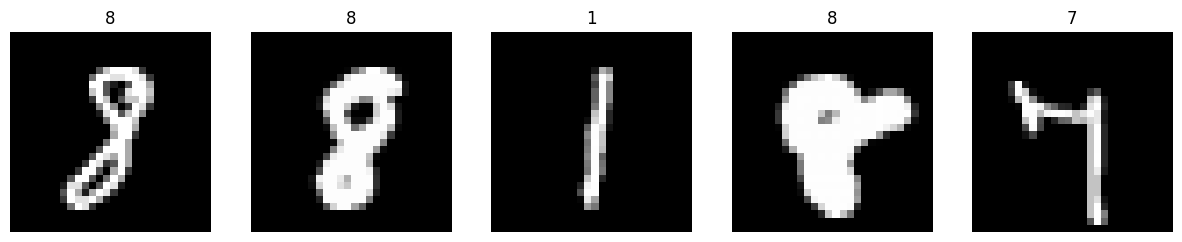

In [18]:

# Début du code
batch = next(iter(train_loader))
x = batch[0][:5]
y = batch[1][:5]

# Configuration pour les images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Boucle pour afficher chaque image
for i in range(5):
    image = x[i].numpy().squeeze()  
    label = y[i].item()

    axes[i].imshow(image, cmap='gray') 
    axes[i].set_title(f'{label}')
    axes[i].axis('off')

plt.show()


In [23]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super().__init__()
        
        # Définition de l'architecture du réseau
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=n_kernels, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=n_kernels * 4 * 4, out_features=50),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.net(x)

n_kernels = 6
input_size = 28 * 28
output_size = 10 

model = ConvNet(input_size=input_size, n_kernels=n_kernels, output_size=output_size)
model.to(device)
print(model)


ConvNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=96, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [24]:
def train(model, perm=torch.arange(0, 784).long(), n_epochs=1):
    model.train()    
    optimizer = torch.optim.AdamW(model.parameters())
    
    for epoch in range(n_epochs):
        for i, (data, target) in enumerate(train_loader):
            # send to device
            data, targets = data.to(device), target.to(device)

            # permute pixels
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)

            # step
            optimizer.zero_grad()
            logits = model(data)
            
            loss = F.cross_entropy(logits, targets)
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"epoch={epoch}, step={i}: train loss={loss.item():.4f}")

In [25]:
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    for data, targets in test_loader:
        # send to device
        data, targets = data.to(device), targets.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        # metrics
        logits = model(data)
        test_loss += F.cross_entropy(logits, targets, reduction='sum').item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == targets).sum()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    print(f"test loss={test_loss:.4f}, accuracy={accuracy:.4f}")

In [27]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernel, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernel, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=n_kernel, out_channels=n_kernel, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=n_kernel * 4 * 4, out_features=50),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.net(x)

In [36]:
train(model)

epoch=0, step=0: train loss=0.0360
epoch=0, step=100: train loss=0.1241
epoch=0, step=200: train loss=0.1622
epoch=0, step=300: train loss=0.0860
epoch=0, step=400: train loss=0.2040
epoch=0, step=500: train loss=0.1430
epoch=0, step=600: train loss=0.2331
epoch=0, step=700: train loss=0.1175
epoch=0, step=800: train loss=0.1965
epoch=0, step=900: train loss=0.1260


In [38]:
test(model)

test loss=0.0762, accuracy=0.9769
